In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex']=True
import scipy
from scipy import interpolate
import scipy.integrate as si

import sys, platform, os
from pylab import imshow,cm
from matplotlib.colors import LogNorm


In [2]:
# Cosmology matching CAMB.ini file for Illustris
omega_baryon   = 0.0486
omega_cdm      = 0.2603
omega_lambda   = 0.6911

Omega_m = omega_baryon+omega_cdm
Omega_l = 1.- Omega_m

h = 0.6774
H0 = 100.
c = 3e5

#we use this function to compute the comoving distance to a given redshift
def func(y,x,Omega_M,Omega_L):
    return [1.0/np.sqrt(Omega_M*(1.0+x)**3+Omega_L)]
##############################################################################

##############################################################################
#This functions computes the comoving distance to redshift z, in Mpc/h
#As input it needs z, Omega_m and Omega_L. It assumes a flat cosmology
def comoving_distance(z,Omega_M,Omega_L):
    H0=100.0 #km/s/(Mpc/h)
    c=3e5    #km/s
    #compute the comoving distance to redshift z
    yinit=[0.0]
    z_limits=[0.0,z]
    I=si.odeint(func,yinit,z_limits,args=(Omega_M,Omega_L),
                rtol=1e-8,atol=1e-8,mxstep=100000,h0=1e-6)[1][0]
    r=c/H0*I
    return r

z_dcom = np.linspace(0,7.,1000)
Dc = np.zeros(z_dcom.size)
for i,r in enumerate(z_dcom):
    Dc[i] = comoving_distance(r,Omega_m,Omega_l)    
Dcom = scipy.interpolate.interp1d(z_dcom, Dc, kind='linear')

# Here we also define E(z) since we will need it to compute the comoving volumes:
def E(z):
    return np.sqrt(Omega_l + Omega_m*(1+z)**3)

# A function for computing comoving volume (used to compute survey volume in a redshift bin and in a pixel)
survey_volume = lambda x : c*Dcom(x)**2/E(x)/(100.)
    
def Vsurvey(z,dz,S21):
    return S21*scipy.integrate.quad(survey_volume,z-dz/2.,z+dz/2.,epsabs=1e-10)[0]

def Omega_HI(z):
    return 0.0004*(1+z)**0.6

def TbHI(z):
    return 180.*Omega_HI(z)*(1+z)**2*h/E(z)

0.118661882996 148.550179743


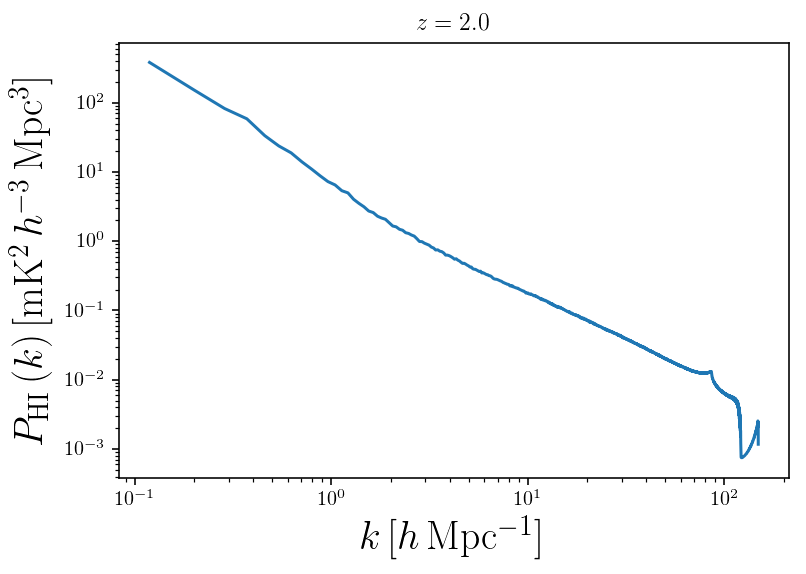

In [30]:
# Load Pk HI

zz = 2.

k, Pk = np.loadtxt('../HI_Illustris/HI_redshift-space/Pk_HI_RS_0_z='+str(int(zz))+'.0.txt', unpack=True)

plt.loglog(k,Pk*TbHI(zz)**2)
print k.min(), k.max()
plt.xlabel("$k\,[h\,\mathrm{Mpc^{-1}}]$", fontsize = 20)
plt.ylabel("$P_\mathrm{HI}\,(k)\,[\mathrm{mK^2}\,h^{-3}\,\mathrm{Mpc^3}]$", fontsize = 20)
plt.title('$z=%.1f$'%zz)#+ '$,\,\mu=0.5$')

## Characteristics of a survey

In [31]:
Ta   = 10*1e3   # [K]
S21  = 25000.*(np.pi/180.)**2 # srad
Nd   = 256.*256.
t0   = 1e4*3600 # [sec], 1e4 h ~ 1yr
npol = 2.
Ddish= 6.     # [m]
Aeff = np.pi*(Ddish/2)**2  # [m^2]
Dmin = Ddish
Dmax = np.sqrt(Nd*2.)*Ddish
print Dmax, Dmin, S21

2172.23203181 6.0 7.61543549467


## Here we define the noise power spectrum

In [32]:
# Field of view
def FOV(z): # srad
    return (1.22*0.211*(1.+z)/Ddish)**2

# Number density of samples in the uv plane
def nu(z):
    return Nd**2 / (2.*np.pi*Dmax**2/(0.211*(1.+z))**2)

# Sky temperature
def Tsky(z):
    return 60.*(1420./(1.+z)/300.)**(-2.55)*1e3 # [mK]

# System temperature
def Tsys(z):
    return Ta + Tsky(z) # [mK]

# Conversion factors X and Y that convert volume element from angles and freqs to comoving cosmic volume element
def X(z):
    return Dcom(z)
def Y(z):
    return 3e5*(1+z)**2/(1420.*1e6*H0*E(z))

# Noise Power spectrum
def PNoise_level(z):
    return Tsys(z)**2 *X(z)**2*Y(z) *(0.211*(1.+z))**4/Aeff**2\
            *S21/FOV(z) /(t0*npol*nu(z))

## Let's add window function and the wedge

In [33]:
def k_perp_min(z):
    return 2.*np.pi*Dmin/Dcom(z)/0.211/(1.+z)

def k_perp_max(z):
    return 2.*np.pi*Dmax/Dcom(z)/0.211/(1.+z)

def k_par_min(z):
    return 1e-2
#     return 2.*np.pi/(Vsurvey(z)**(1./3.))

# def k_par_max(z):
#     return 0.14/h*(1.+z)**(2./3.)

# Window function
def W(z,k,mu):
    return 0.5*(np.sign(k_perp_max(z)-k*np.sqrt((1.-mu**2)))+1.)\
            *0.5*(np.sign(k*np.sqrt((1.-mu**2))-k_perp_min(z))+1.)\
                *0.5*(np.sign(k*mu-k_par_min(z))+1.)#*0.5*(np.sign(knl(z)-k)+1.)\

def mumin_fov(z):
    sin_theta = np.sin(1.22*0.211*(1.+z)/Ddish)
    return sin_theta*Dcom(z)*H0*E(z)/(c*(1+z))\
                /np.sqrt(1+(sin_theta*Dcom(z)*H0*E(z)/(c*(1+z)))**2)
def Wedge(z,mu):
    return 0.5*(np.sign(mu-mumin_fov(z))+1.)

# Noise power spectrum with the effect of the available modes 
def PN(z,k,mu):
    return np.where(Wedge(z,mu)*W(z,k,mu)*PNoise_level(z)==0, np.inf, Wedge(z,mu)*W(z,k,mu)*PNoise_level(z))
#     return np.where(W(z,k,mu)*PNoise(z)==0, np.inf, W(z,k,mu)*PNoise(z))

# Signal power spectrum, only monopole now
def PS(kk,mu):
    return np.interp(kk,k,Pk)

## Let's see how these power spectra look like

PNOISE =  1.4986795027


(0.01, 100.0)

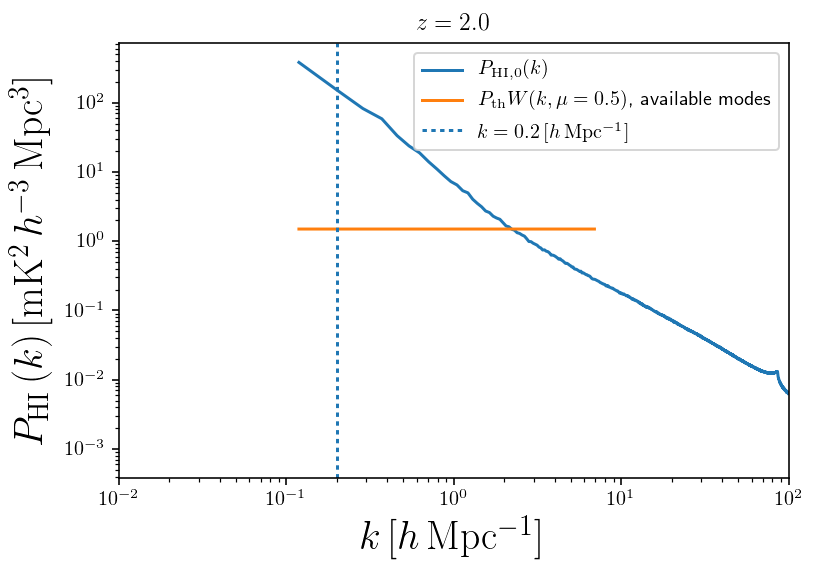

In [34]:
print 'PNOISE = ', PNoise_level(zz)
plt.plot(k,Pk*TbHI(zz)**2, label = '$P_\mathrm{HI,0}(k)$')
plt.plot(k,PN(zz,k,0.5), label = '$P_\mathrm{th}W(k,\\mu=0.5)$, available modes')
# plt.axhline(y=PNoise_level(zz), color = 'm', label = '$P_\mathrm{th}$')
plt.axvline(x=0.2, linestyle='dotted', label = '$k=0.2\,[h\,\mathrm{Mpc^{-1}}]$')
plt.xlabel("$k\,[h\,\mathrm{Mpc^{-1}}]$", fontsize = 20)
plt.ylabel("$P_\mathrm{HI}\,(k)\,[\mathrm{mK^2}\,h^{-3}\,\mathrm{Mpc^3}]$", fontsize = 20)
plt.title('$z=%.1f$'%zz)#+ '$,\,\mu=0.5$')
plt.xscale("log")
plt.yscale("log")
plt.legend(loc=0, fontsize=10)
plt.xlim(xmin=1e-2, xmax=100.)

In [39]:
def dF(kk,mu,z):
    return 2.*Vsurvey(z,0.1,S21)*t0**2/(24.*np.pi**2)*kk**4*mu**2*PS(kk,mu)*TbHI(z)**2/PN(z,kk,mu)

#2D integration function
def integrate2D(dfun, kgrid, mugrid):
    muint = [scipy.integrate.simps(dfun.T[i], mugrid) for i in range(kgrid.size)]
    return scipy.integrate.simps(muint, kgrid)


mugrid = np.linspace(0.,1,500)
kgrid  = np.linspace(k.min(), 0.5, 500)
K, MU = np.meshgrid(kgrid, mugrid)

# Faa in units of sec/(Mpc/h)^2:
Faa = integrate2D(dF(K,MU,zz),kgrid,mugrid)

# alpha in units of Mpc/year
print '1 sigma on alpha', np.sqrt(1./Faa)*(365.25*24.*60.*60)/h

# alpha in the same units (from the draft):
print 'alpha', 3e-7*((1+zz)/(Omega_m*(1.+zz)**3+Omega_l)-1.)

1 sigma on alpha 0.00054825996332
alpha -2.00347675886e-07


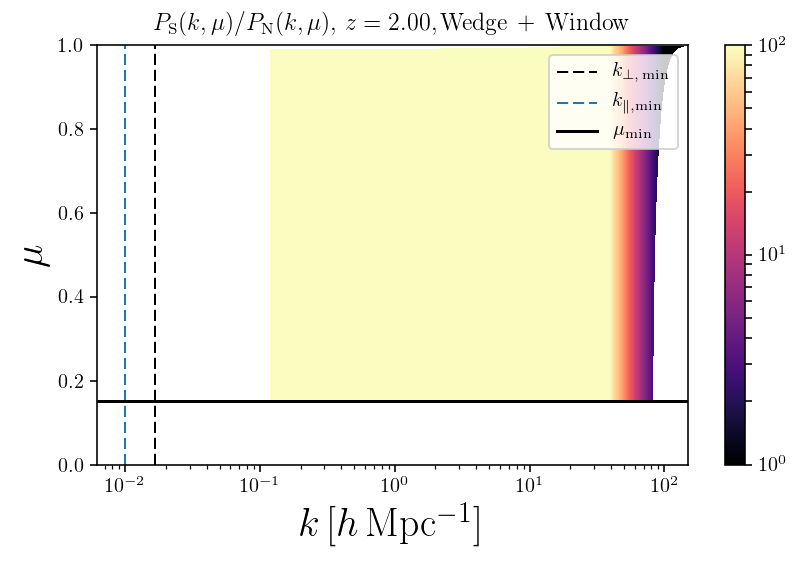

In [36]:
Nk = 1000; Nmu = 500
kgrid = np.logspace(np.log10(k.min()),np.log10(k.max()),Nk)
mugrid = np.linspace(0.,1.,Nmu)
K, MU = np.meshgrid(kgrid,mugrid)
Test1 = PS(K,MU)/PN(zz,K,MU)
plt.imshow(Test1, origin='lower',norm=LogNorm(vmin = 1, vmax=1e2), aspect='auto',interpolation='nearest',\
          extent=(K.min(),K.max(),MU.min(),MU.max()), cmap='magma')
plt.xscale('log')
plt.xlabel('$k\,[h\,\mathrm{Mpc^{-1}}]$', fontsize = 20)
plt.ylabel('$\mu$', fontsize =20)
plt.title('$P_\\mathrm{S}(k,\\mu)/P_\mathrm{N}(k,\\mu),\,z=%.2f, \mathrm{Wedge\,+\,Window}$'%zz)
plt.axvline(x=k_perp_min(zz), linestyle = 'dashed', linewidth = 1, color = 'k', label = '$k_{\\perp,\,\mathrm{min}}$')
plt.axvline(x=k_par_min(zz), linestyle = 'dashed', linewidth = 1,  label = '$k_{\\parallel,\mathrm{min}}$')
plt.axhline(y=mumin_fov(zz), color='k', label = '$\\mu_\\mathrm{min}$')
plt.colorbar()
plt.legend(loc=0)
plt.tight_layout()
# plt.savefig('k_mu_plot_Window_k02_2x_Ta50.pdf', bbox_inches='tight')

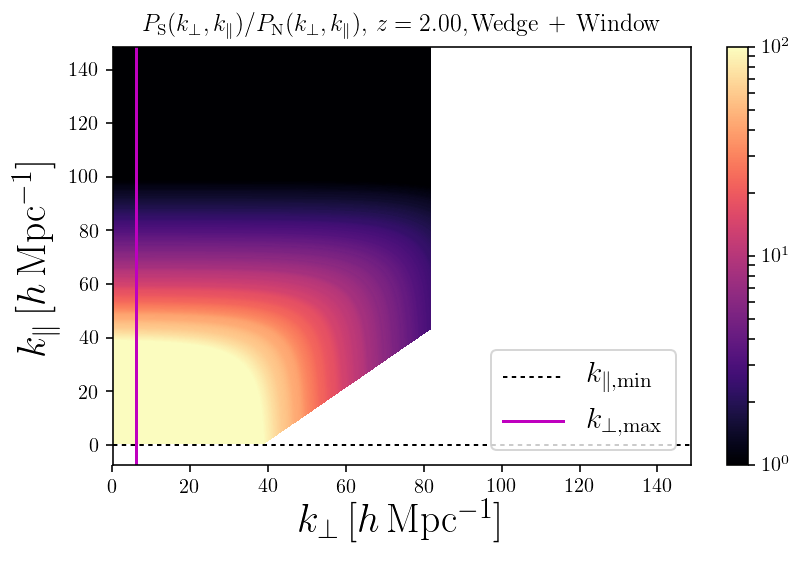

In [38]:
Nkpp = 2000; 
kperpgrid = np.logspace(np.log10(k.min()),np.log10(k.max()),Nkpp)
kparagrid = np.logspace(np.log10(k.min()),np.log10(k.max()),Nkpp)
KPer, KPar = np.meshgrid(kperpgrid,kparagrid)
KKK = np.sqrt(KPar**2+KPer**2)
MY  = KPar/KKK
Test1 = PS(KKK,MY)/PN(zz,KKK,MY)
plt.imshow(Test1, origin='lower',norm=LogNorm(vmin = 1, vmax=1e2), aspect='auto',interpolation='nearest',\
          extent=(KPer.min(),KPer.max(),KPar.min(),KPar.max()), cmap='magma')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$k_\perp\,[h\,\mathrm{Mpc^{-1}}]$', fontsize = 20)
plt.ylabel('$k_\parallel\,[h\,\mathrm{Mpc^{-1}}]$', fontsize =20)
plt.title('$P_\\mathrm{S}(k_\perp,k_\parallel)/P_\mathrm{N}(k_\perp,k_\parallel),\,z=%.2f, \mathrm{Wedge\,+\,Window}$'%zz)

plt.axhline(y=k_par_min(zz), linestyle = 'dotted', linewidth = 1, color = 'k', label = '$k_{\\parallel,\mathrm{min}}$')
plt.axvline(x=k_perp_max(zz), linestyle='solid', color='m', label = '$k_{\\perp,\mathrm{max}}$')
plt.colorbar()
plt.legend(loc=4, fontsize=15)
plt.tight_layout()
# plt.savefig('SN_kperp_kpar.pdf', bbox_inches='tight')